In [1]:
from magpie import grasp as gt
import rtde_control
import rtde_receive
from magpie.motor_code import Motors
from magpie import ur5 as ur5
import time
import numpy as np
import copy
import magpie
from magpie.gripper import Gripper
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
from open3d.web_visualizer import draw
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()


In [3]:
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit = LabelOWLViT(pth=path)

2024-07-17 17:43:54.227275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 17:43:54.227302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 17:43:54.228363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 17:43:54.233580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 17:43:54.997297: W tensorflow/compiler/tf2

In [19]:
class Perception:
    def __init__(self, num_blocks, query, abbrevq):
        self.ur = ur5.UR5_Interface()
        self.merged_pcd = o3d.geometry.PointCloud()
        self.query = query
        self.abbrevq = abbrevq
        self.blocks = num_blocks
        self.sleep_rate = 3
        self.objects = {}
        
        
    def start_interface(self):
        self.ur.start()

    def stop_interface(self):
        self.ur.stop()

    def open_gripper(self):
        self.ur.open_gripper()

    def close_gripper(self):
        self.ur.close_gripper()

    def move_to_pose(self, pose):
        self.ur.moveL(pose)
        time.sleep(self.sleep_rate)
        time.sleep(self.sleep_rate)


    def get_pose(self):
        return self.ur.get_tcp_pose()
    
    def transform_point_cloud(self, cpcd):
        rotation_matrix = np.array([[0, 1, 0, 0],
                                    [-1, 0, 0, 0],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]])

        tmat_gripper = np.array([[1, 0, 0, -1.15 / 100],
                                 [0, 1, 0, 1.3 / 100],
                                 [0, 0, 1, (309.63 - 195.0) / 1000],
                                 [0, 0, 0, 1]])

        cpcd.transform(tmat_gripper)
        cpcd.transform(rotation_matrix)
        cpcd.transform(self.get_pose())

        return cpcd
    
    def save_point_cloud(self, filename, point_cloud):
         o3d.io.write_point_cloud(filename, point_cloud)

    def save_pose(self, filename, pose):
        np.save(filename, pose)
    
    def load_pose(self, filename):
        return np.load(filename)
    
    def return_to_home(self):
        home = np.load("home_pose.npy")
        self.move_to_pose(home)

    def visualize_point_cloud(self, point_cloud):
        o3d.visualization.draw_geometries([point_cloud])
    
    def get_pcd_pose(self, point_cloud):
        center = point_cloud.get_center()
        #center[2] = center[2] + 233/1000
        pose_vector = [center[0], center[1], center[2], 3.14, 0, 0]
        return pose_vector

    def calculate_area(self, box):
        return abs(box[3] - box[1]) * abs(box[2] - box[0])
    
    def filter_by_area(self, tolerance, box, total_area):
        area = self.calculate_area(box)
        filtered = abs(area/total_area) <= tolerance
        return filtered
        

    def bound(self, query, abbrevq, use_area_calculation=True):
     
        p, rgbd_image = rsc.getPCD()
      
        image = np.array(rgbd_image.color)
        #print(image.shape[0]*image.shape[1])

        label_vit.set_threshold(0.005)
        bboxes, uboxes, scores, labels= label_vit.label(image, query, abbrevq, topk=True, plot=False)

        scores = sorted(scores, reverse=True)
        filtered_boxes = []
        filtered_scores = []
        filtered_labels = []
        filter_coords =[]
        for i in range(min(20, len(label_vit.sorted_labeled_boxes_coords))):
            if self.filter_by_area(0.05, label_vit.sorted_labeled_boxes_coords[i][0], image.shape[0]*image.shape[1]):
                filtered_boxes.append(label_vit.sorted_boxes[i])
                filtered_scores.append(scores[i])
                filtered_labels.append(labels[i])
                filter_coords.append(label_vit.sorted_labeled_boxes_coords[i])

        return rgbd_image, image, abbrevq, filtered_boxes, filtered_scores, filtered_labels, filter_coords
   
    def combine_class_labels(self, images,abbrevqs, filtered_scores, filtered_boxes, filtered_labels):

        
        self.plot_bounding_boxes(images, filtered_scores, filtered_boxes, filtered_labels, topk=False, show_plot=True)

    def combine_class_labels1(self, images,abbrevqs, filtered_scores, filtered_boxes, filtered_labels):

        self.plot_bounding_boxes1(images, filtered_scores, filtered_boxes, filtered_labels, topk=False, show_plot=True)

  
    def calculate_probability_dist(self, cluster):
            
            probabilities = {color: 0 for color in self.abbrevq}
            total = len(cluster)
            
            color_counts = {color: 0 for color in self.abbrevq}

            for i in range(len(cluster)):
                    color_counts[cluster[i][1]] += 1

            for key in color_counts.keys():
                probabilities[key] = color_counts[key] / total

            return probabilities
            

    def format_coordinates(self, box):
        
        cx, cy, w, h = box
    
        return [cx - w/2, cy + h/2, cx + w/2, cx - h/2]
  
    def find_eucledian_distance(self, point1, point2):
        return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

            

    def plot_bounding_boxes(self,  input_image, scores, boxes, labels, topk=False, show_plot=False):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(input_image, extent=(0, 1, 1, 0))
        ax.set_axis_off()
        idx = 0
        for i in range(self.blocks):
            print(f"Block {i+1}")
            iter = 0
            for score, box, label in zip(scores[i], boxes[i], labels[i]):
                print([idx, self.abbrevq[i], score, box])
                if score < label_vit.SCORE_THRESHOLD:
                    continue
                cx, cy, w, h = box
                ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
                        [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
                ax.text(
                    cx - w / 2,
                    cy + h / 2 + 0.015,
                    f"({idx}): {score:1.2f}",
                    ha="left",
                    va="top",
                    color=self.abbrevq[i],
                    bbox={
                        "facecolor": "white",
                        "edgecolor": "red",
                        "boxstyle": "square,pad=.3"
                    })
                idx += 1
                iter+=1
            
            fig.canvas.draw()
            
            if not show_plot: plt.close(fig) 

    def plot_bounding_boxes1(self,  input_image, scores, boxes, labels, topk=False, show_plot=False):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(input_image, extent=(0, 1, 1, 0))
        ax.set_axis_off()
        idx = 0
        
        for score, box, label in zip(scores, boxes, labels):
            if score < label_vit.SCORE_THRESHOLD:
                continue
            cx, cy, w, h = box
            ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
                    [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
            ax.text(
                cx - w / 2,
                cy + h / 2 + 0.015,
                f"({idx}): {score:1.2f}",
                ha="left",
                va="top",
                color=self.abbrevq[label],
                bbox={
                    "facecolor": "white",
                    "edgecolor": "red",
                    "boxstyle": "square,pad=.3"
                })
            idx += 1
        
        fig.canvas.draw()
        
        if not show_plot: plt.close(fig) 

    def assign_label(self, k, boundaries):
            # Calculate the cumulative boundaries
            output_list = [sum(boundaries[:i+1])-1 for i in range(len(boundaries))]

            # Find the interval in which k lies
            for i in range(len(output_list)):
                if k <= output_list[i]:
                    return i  # Return the interval label (1-indexed)
                


    def find_clusters(self, boxes, scores_list):
        bounding_boxes = []
        boundaries = []
        scores = []
        for i in range(len(boxes)):
                boundaries.append(len(boxes[i]))
                bounding_boxes.extend(boxes[i])
                scores.extend(scores_list[i])

        minw = float('inf')
        for box in bounding_boxes:
            if box[2] < minw:
                minw = box[2]

        clustered_objects = []
        while True:
            clusters = []
            temp = None

            for i in range(len(bounding_boxes)):
                if bounding_boxes[i] is not None:
                    if not clusters:
                        temp = bounding_boxes[i]
                        k = self.assign_label(i, boundaries)
                        print(bounding_boxes[i])
                        print(k)
                        clusters.append([bounding_boxes[i], self.abbrevq[k], scores[i], i])
                        bounding_boxes[i] = None
                    else:
                        if self.find_eucledian_distance([temp[0], temp[1]], [bounding_boxes[i][0], bounding_boxes[i][1]]) < minw:
                            k = self.assign_label(i, boundaries)
                            print(bounding_boxes[i])
                            print(k)
                            clusters.append([bounding_boxes[i], self.abbrevq[k], scores[i], i])
                            bounding_boxes[i] = None

            clustered_objects.append(clusters)
            if all(x is None for x in bounding_boxes) or len(clusters) == 1:
                break

        return clustered_objects

    def build_model(self, n):
        try:
            self.start_interface()

            for i in range(n):
                images, abbrevqs, filtered_boxes, filtered_scores, filtered_labels, filtered_coords = [], [], [], [], [], []
                
                for j in range(len(self.query)):
                    rgbd, image, abbrevq, boxes, scores, labels, coords = self.bound(self.query[j], self.abbrevq[j])
                    abbrevqs.append(abbrevq)
                    filtered_boxes.append(boxes)
                    filtered_scores.append(scores)
                    filtered_labels.append(labels)
                    filtered_coords.append(coords)
                    self.combine_class_labels1(image, abbrevq, scores, boxes, labels)

                clusters = self.find_clusters(filtered_boxes, filtered_scores)
                self.objects = {f'Object {objectnum + 1}': {} for objectnum in range(len(clusters))}
                index_to_segment = [max(cluster, key=lambda x: x[2])[3] for cluster in clusters]
                formatted_boxes = [box for box_list in filtered_coords for box in box_list]

                for i in range(len(clusters)):
                    for j in range(len(clusters[i])):
                        print(clusters[i][j])
                    print('-----------------------')
                



                for num, index in enumerate(index_to_segment):


                    _, cpcd, _, _ = pcd.get_segment(
                        formatted_boxes, 
                        index, 
                        rgbd, 
                        rsc, 
                        type="box", 
                        method="iterative", 
                        display=False, 
                        viz_scale=1000
                    )
                    
                
                    cpcd = self.transform_point_cloud(cpcd)
                    #self.visualize_point_cloud(cpcd)
                    #self.save_point_cloud(f'object_{num + 1}.pcd', cpcd)
                    self.objects[f'Object {num + 1}']['Probability'] = self.calculate_probability_dist(clusters[num])
                    
                    self.objects[f'Object {num + 1}']['Pose'] = self.get_pcd_pose(cpcd)
                    
                self.combine_class_labels(image, abbrevqs, filtered_scores, filtered_boxes, filtered_labels)
            
            self.stop_interface()
            return self.objects

        except Exception as e:
            self.stop_interface()
            raise e

  

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
[0.497 0.471 0.046 0.08 ]
0
[0.497 0.471 0.047 0.08 ]
1
[0.498 0.472 0.044 0.073]
1
[0.498 0.479 0.038 0.064]
1
[0.497 0.471 0.047 0.08 ]
2
[0.497 0.651 0.056 0.104]
0
[0.497 0.651 0.056 0.105]
1
[0.497 0.651 0.056 0.106]
2
[0.578 0.564 0.056 0.096]
0
[0.578 0.564 0.056 0.097]
2
[array([0.497, 0.471, 0.046, 0.08 ], dtype=float32), 'purple', 0.019980114, 0]
[array([0.497, 0.471, 0.047, 0.08 ], dtype=float32), 'blue', 0.06058233, 3]
[array([0.498, 0.472, 0.044, 0.073], dtype=float32), 'blue', 0.0070139007, 5]
[array([0.498, 0.479, 0.038, 0.064], dtype=float32), 'blue', 0.005086215, 6]
[array([0.497, 0.471, 0.047, 0.08 ], dtype=float32), 'red', 0.009868364, 9]
-----------------------
[array([0.497, 0.651, 0.056, 0.104], dtype=float32), 'purple', 0.01811287, 1]
[array([0.497, 0.651, 0.056, 0.105], dtype=float32), 'blue', 0.019628642, 4]
[array([0.497, 0.65

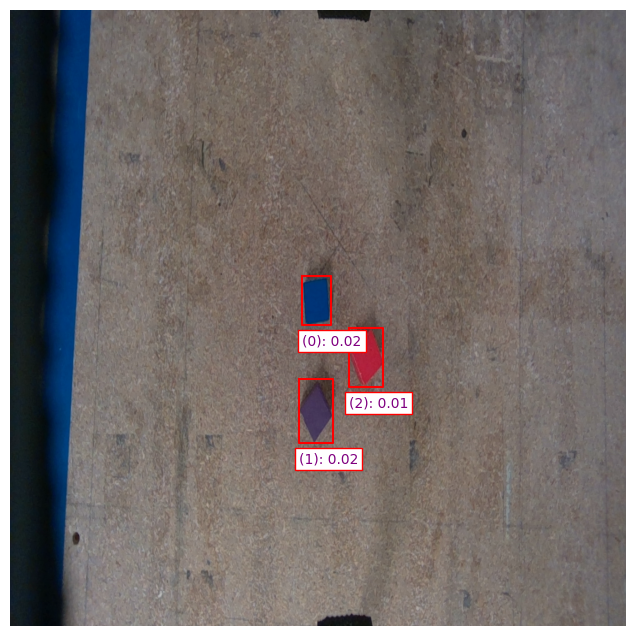

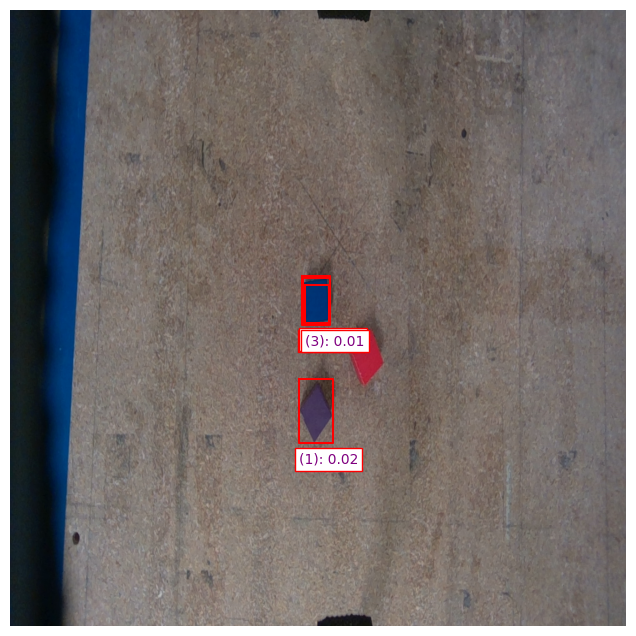

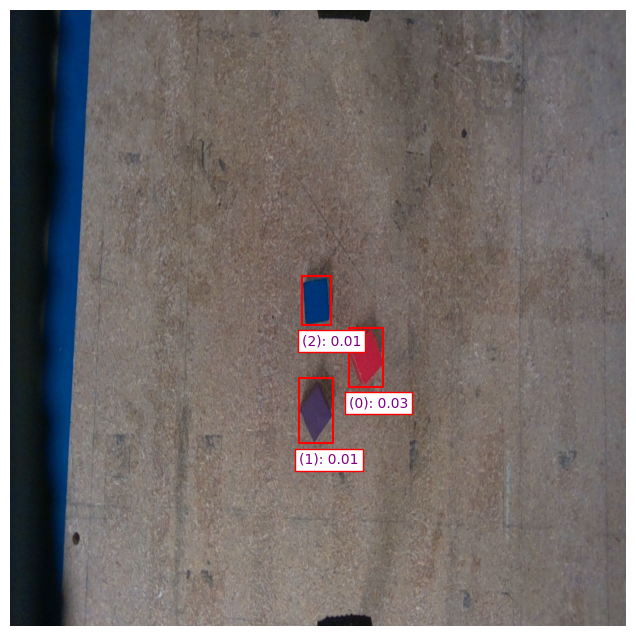

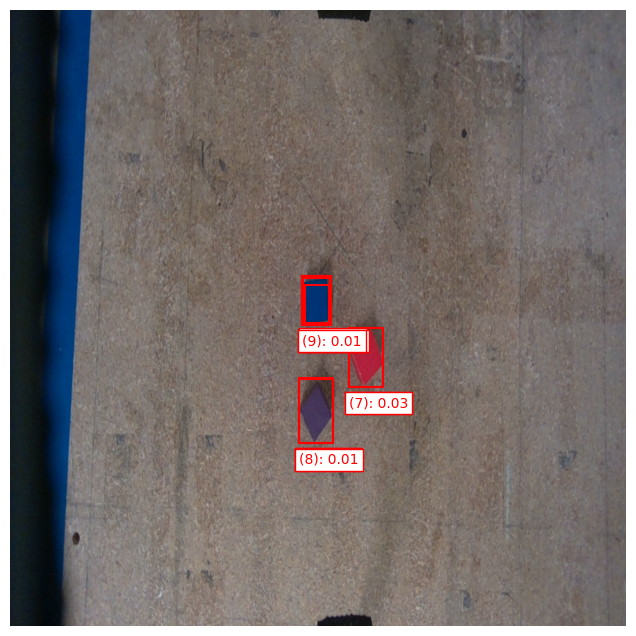

In [20]:
queries = ["a photo of a purple block", "a photo of a blue block", "a photo of a red block"]
abbrevq = ["purple", "blue", "red"]
num_blocks = 3
iterations_per_pose = 1

tower = Perception(num_blocks, queries, abbrevq)
print(tower.build_model(iterations_per_pose))

In [6]:
  # def build_model(self, n):
    #     try:
    #         self.start_interface()

    #         for i in range(n):
    #                 images = []
    #                 abbrevqs = []
    #                 filtered_boxes = []
    #                 filtered_scores = []
    #                 filtered_labels = []
    #                 for j in range(len(self.query)):
    #                     rgbd, image, abbrevq, boxes, scores, labels = self.bound(self.query[j], self.abbrevq[j])
    #                     abbrevqs.append(abbrevq)
    #                     filtered_boxes.append(boxes)
    #                     filtered_scores.append(scores)
    #                     filtered_labels.append(labels)

    #                 x = self.find_clusters(filtered_boxes, filtered_scores)
    #                 index_to_segment = []
    #                 self.objects = {f'Object {objectnum+1}' : {} for objectnum in range(len(x))}

    #                 for z in range(len(x)):
    #                     max_score = 0

    #                     probability = self.calculate_probability_dist(x[z])
    #                     self.objects[f'Object {z+1}']['Probability'] = probability

    #                     for y in range(len(x[z])):
    #                         if x[z][y][2] > max_score:
    #                             max_score = x[z][y][2]
    #                             max_index = x[z][y][3]
    #                         #print(x[z][y])

    #                     index_to_segment.append(max_index)    
    #                     #print('----------------------')

    #                 formatted_boxes = []
    #                 for numa in range(len(filtered_boxes)):
    #                     for j in range(len(filtered_boxes[numa])):
    #                         formatted_boxes.append((filtered_boxes[numa][j],0))
                        
    #                 print(formatted_boxes)

    #                 for num, index in enumerate(index_to_segment):
    #                     print(index)
    #                     print(formatted_boxes[index])
    #                     _, cpcd, _, _ = pcd.get_segment(formatted_boxes, 
    #                                                                         index, 
    #                                                                         rgbd, 
    #                                                                         rsc, 
    #                                                                         type="box", 
    #                                                                         method="iterative", 
    #                                                                         display=False,
    #                                                                         viz_scale=1000)
                        
                        
                        
    #                     plt.subplot(1, 2, 1)
    #                     plt.imshow(rgbd.color)
    #                     plt.subplot(1, 2, 2)
    #                     plt.imshow(rgbd.depth)
    #                     plt.show()
                        
    #                     cpcd = self.transform_point_cloud(cpcd)
    #                     self.save_point_cloud(f'object_{num+1}.pcd', cpcd)

    #                     self.objects[f'Object {num+1}']['Pose'] = self.get_pcd_pose(cpcd)

                        
                        
                  
                    
                    
    #                 self.combine_class_labels(image, abbrevqs, filtered_scores, filtered_boxes, filtered_labels)
                        
                  
                    
                    
    #         self.stop_interface()

    #         return self.objects

            
    #     except Exception as e:

    #         self.stop_interface()
    #         raise e
        
    

In [7]:
def calculate_probability_dist(cluster):
            
            probabilities = {'blue': 0, 'red': 0, 'purple': 0}
            total = len(cluster)
            
            color_counts = {'blue': 0, 'red': 0, 'purple': 0}

            for i in range(len(cluster)):
                    color_counts[cluster[i][1]] += 1

            for key in color_counts.keys():
                probabilities[key] = color_counts[key] / total

            return probabilities
            

In [8]:
data = [[0, 'blue'], [0, 'red'], [0, 'blue'], [0, 'purple']]
print(calculate_probability_dist(data))

{'blue': 0.5, 'red': 0.25, 'purple': 0.25}


In [9]:
def assign_label(k, boundaries):
        k+=1
        # Calculate the cumulative boundaries
        output_list = [sum(boundaries[:i+1]) for i in range(len(boundaries))]
        print(output_list[-1])

        # Find the interval in which k lies
        for i in range(len(output_list)):
            if k <= output_list[i]:
                return i  # Return the interval label (1-indexed)
            if k == output_list[-1]+1:
                return len(output_list)
     

In [10]:
data = [5, 4, 4]
print(assign_label(5, data))

13
1


In [ ]:
def find_clusters(self, boxes, scores_list):
        bounding_boxes = []
        boundaries = []
        scores = []
        for i in range(len(boxes)):
                boundaries.append(len(boxes[i]))
                bounding_boxes.extend(boxes[i])
                scores.extend(scores_list[i])
                
        clustered_objects = []
        while True:
            clusters = []
            temp = None

            for i in range(len(bounding_boxes)):
                if bounding_boxes[i] is not None:
                    if not clusters:
                        temp = bounding_boxes[i]
                        k = self.assign_label(i, boundaries)
                        clusters.append([bounding_boxes[i], self.abbrevq[k], scores[i], i])
                        bounding_boxes[i] = None
                    else:
                        if self.find_eucledian_distance([temp[0], temp[1]], [bounding_boxes[i][0], bounding_boxes[i][1]]) < minw:
                            k = self.assign_label(i, boundaries)
                            clusters.append([bounding_boxes[i], self.abbrevq[k], scores[i], i])
                            bounding_boxes[i] = None

            clustered_objects.append(clusters)
            if all(x is None for x in bounding_boxes) or len(clusters) == 1:
                break

        return clustered_objects